## Particiones
En esta notebook vamos a buscar las particiones en comunidades de los grafos cortados con tres algoritmos distintos.
Luego guardamos en jsons los porcentajes de diputadxs por bloque en cada particion.

In [32]:
from networkx_graph import RepresentativesGraph
import networkx as nx # Para redes en general
from new_disparity_filter import NewDisparityFilter
from procesador_votaciones import ProcesadorDeVotaciones
from heavy_graph_maker import HeavyGraphMaker

import matplotlib.pylab as plt # Para graficar networkx y demases
import matplotlib.cm as cm # para mapas de colores
import numpy as np

In [8]:
years = list(range(1993,2021))
procesador = ProcesadorDeVotaciones(years[0],years[-1], 'data')
congress = procesador.procesar()

#red_igraph = ig.Graph.TupleList(red.edges(), directed=False)


Loading from data/1993/1
Getting data/1993/2 from API
Getting data/1993/3 from API
Getting data/1993/4 from API
Getting data/1993/5 from API
Getting data/1993/6 from API
Getting data/1993/7 from API
Getting data/1993/8 from API
Getting data/1993/9 from API
Getting data/1993/10 from API
Getting data/1993/11 from API
Getting data/1993/12 from API
Loading from data/1994/1
Loading from data/1994/2
Loading from data/1994/3
Loading from data/1994/4
Loading from data/1994/5
Loading from data/1994/6
Loading from data/1994/7
Loading from data/1994/8
Loading from data/1994/9
Loading from data/1994/10
Loading from data/1994/11
Loading from data/1994/12
Loading from data/1995/1
Loading from data/1995/2
Loading from data/1995/3
Loading from data/1995/4
Loading from data/1995/5
Loading from data/1995/6
Loading from data/1995/7
Loading from data/1995/8
Loading from data/1995/9
Loading from data/1995/10
Loading from data/1995/11
Loading from data/1995/12
Loading from data/1996/1
Loading from data/1996

Loading from data/2019/12
Loading from data/2020/1
Loading from data/2020/2
Loading from data/2020/3
Loading from data/2020/4
Loading from data/2020/5
Loading from data/2020/6
Loading from data/2020/7
Loading from data/2020/8
Loading from data/2020/9
Loading from data/2020/10
Loading from data/2020/11
Loading from data/2020/12


In [28]:
alphas  = {}
alphas[1993] = 0.185
alphas[1994] = 0.185
alphas[1995] = 0.21 #dudoso
alphas[1996] = 0.2
alphas[1997] = 0.19
alphas[1998] = 0.24
alphas[1999] = 0.25 #dudoso, GC = 0.8
alphas[2000] = 0.25
alphas[2001] = 0.22
alphas[2002] = 0.17
alphas[2003] = 0.17
alphas[2004] = 0.26 
alphas[2005] = 0.21
alphas[2006] = 0.145
alphas[2007] = 0.13
alphas[2008] = 0.222
alphas[2009] = 0.2
alphas[2010] = 0.22
alphas[2011] = 0.19 #rari
alphas[2012] = 0.231 #many edges
alphas[2013] = 0.32 #5k de edges
alphas[2014] = 0.22
alphas[2015]  = 0.2 
alphas[2016] = 0.26
alphas[2017] = 0.19 #hay un grupo muy separado que si nos vamos a 0.185 se sale de la GC
alphas[2018] = 0.25
alphas[2019] = 0.17
alphas[2020] = 0.3 #9k muy loco, hermoso

### Funciones necesarias

In [34]:
def get_GC(year,alpha,congreso):
    maker = HeavyGraphMaker(congreso)
    grafo = maker.create_year_network(year, positive = True)
    copia = grafo.copy()
    grafo_cortado = NewDisparityFilter(copia).alpha_cut(alpha_t = alpha)
    GC_cut, _ = grafo_cortado.gigant_component()
    return GC_cut

In [21]:
def get_ideologies_dict(graph,year):
    dict_ideologies = {}
    for ideology in file[str(year)]:
        dict_ideologies[ideology] = {}
        nodes = []
        for node in graph.get_nodes():
            if list(node.parties[year])[0].text in file[str(year)][ideology]:
                nodes.append(node)
        dict_ideologies[ideology] = nodes
    return dict_ideologies

In [23]:
def get_weights(graph):
    new_weights = []
    for e in graph.get_edges():
        new_weights.append(graph.graph[e[0]][e[1]]['weight'])
    return new_weights

In [45]:
import funciones as f
from collections import OrderedDict

def get_community_dict(particiones):
    dict_community = {}
    for part in particiones:
        dict_community[part] = {}
        keys = list(OrderedDict.fromkeys(list(particiones[part].values())))
        values = []
        for key in keys:
            values.append([i for i,j in particiones[part].items() if j == key])

        dict_community[part]= {k: values[k] for k in keys}
    return dict_community

In [63]:
def intersection(dict_comm,dict_ideo, dict_a_guardar):
    for algo_i in dict_comm: #recorro las particiones delos distintos algos
        dict_a_guardar[algo_i] = {}
        for particion in dict_comm[algo_i]:
            dict_a_guardar[algo_i]['Partición '+str(particion)] = {}
            a = set(dict_comm[algo_i][particion])
            
            #le agrego el tamanio de cada comunidad como variable
            dict_a_guardar[algo_i]['Partición '+str(particion)]['Tamaño (nodos)'] = {}
            dict_a_guardar[algo_i]['Partición '+str(particion)]['Tamaño (nodos)'] = len(dict_comm[algo_i][particion])
            
            for partido in dict_ideo:
                interseccion = a.intersection(set(dict_ideo[partido]))
                dict_a_guardar[algo_i]['Partición '+str(particion)][partido] = {}
                dict_a_guardar[algo_i]['Partición '+str(particion)][partido] = len(interseccion) / len(a)
    return dict_a_guardar

In [102]:
def plot_graph_ideologies(dict_part,graph):
    fig, axs = plt.subplots(1,3, figsize=(15,5))
    pos = nx.spring_layout(graph)
    for i,metodo in enumerate(dict_part):

        particion = dict_part[metodo]
        colores = f.colores_hex(max(particion.values())+1) #funcion que devuelve n colores

        #nx.draw(Red_delfines, node_size= 100, ax = axs[i], node_color = node_color,pos=posiciones, node_shape = aShape,  nodelist = node_list)
        nx.draw_networkx_nodes(graph, ax = axs[i],node_size=10, node_color=list(particion.values()),nodelist = list(particion.keys()),pos=pos)
        nx.draw_networkx_edges(graph, ax = axs[i], width=1.0, alpha=0.01,pos=pos)
        axs[i].set_title(metodo)
        axs[i].axis('off')


In [107]:
#cargo el json con las ideologias
import yaml
file = open('configs/ideologies.json').read()


## Grafos
Aca iteramos las funciones para cada anio. Nos guarda las figuras como imagenes y los dicts de interesccion en jsons.

The graph has 24077 edges
Max alpha is 0.8682601008947574, min alpha is 0.00047550923055756413
Enlaces sacados: 1000
Enlaces sacados: 2000
Enlaces sacados: 3000
Enlaces sacados: 4000
Enlaces sacados: 5000
Enlaces sacados: 6000
Enlaces sacados: 7000
Enlaces sacados: 8000
Enlaces sacados: 9000
Enlaces sacados: 10000
Enlaces sacados: 11000
Enlaces sacados: 12000
Enlaces sacados: 13000
Enlaces sacados: 14000
Enlaces sacados: 15000
Enlaces sacados: 16000
Enlaces sacados: 17000
17524 edges deleted, 6553 left. 27.217% left.
Gigant component is 0.9115384615384615 of the total
The graph has 16885 edges
Max alpha is 0.8955735465567767, min alpha is 0.014555190523415234
Enlaces sacados: 1000
Enlaces sacados: 2000
Enlaces sacados: 3000
Enlaces sacados: 4000
Enlaces sacados: 5000
Enlaces sacados: 6000
Enlaces sacados: 7000
Enlaces sacados: 8000
Enlaces sacados: 9000
Enlaces sacados: 10000
Enlaces sacados: 11000
Enlaces sacados: 12000
Enlaces sacados: 13000
Enlaces sacados: 14000
14058 edges deleted

The graph has 26699 edges
Max alpha is 0.9661479074230014, min alpha is 0.006290054516902114
Enlaces sacados: 1000
Enlaces sacados: 2000
Enlaces sacados: 3000
Enlaces sacados: 4000
Enlaces sacados: 5000
Enlaces sacados: 6000
Enlaces sacados: 7000
Enlaces sacados: 8000
Enlaces sacados: 9000
Enlaces sacados: 10000
Enlaces sacados: 11000
Enlaces sacados: 12000
Enlaces sacados: 13000
Enlaces sacados: 14000
Enlaces sacados: 15000
Enlaces sacados: 16000
Enlaces sacados: 17000
Enlaces sacados: 18000
Enlaces sacados: 19000
19959 edges deleted, 6740 left. 25.244% left.
Gigant component is 0.9128787878787878 of the total
The graph has 21672 edges
Max alpha is 0.9698818298353061, min alpha is 0.04220997379406387
Enlaces sacados: 1000
Enlaces sacados: 2000
Enlaces sacados: 3000
Enlaces sacados: 4000
Enlaces sacados: 5000
Enlaces sacados: 6000
Enlaces sacados: 7000
Enlaces sacados: 8000
Enlaces sacados: 9000
Enlaces sacados: 10000
Enlaces sacados: 11000
Enlaces sacados: 12000
Enlaces sacados: 13000

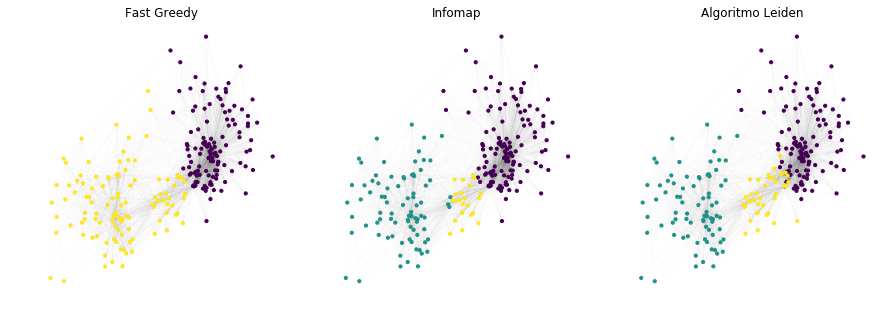

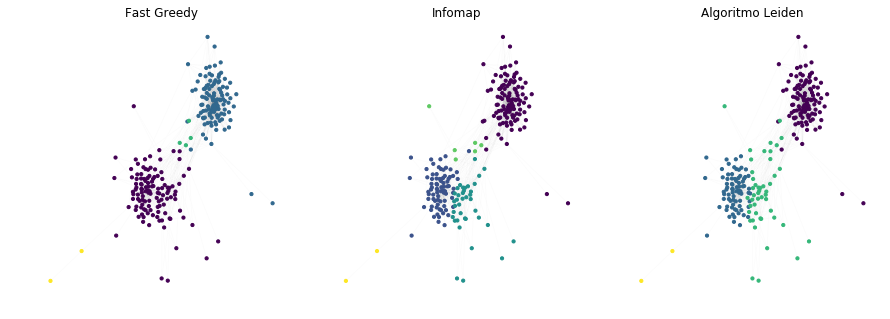

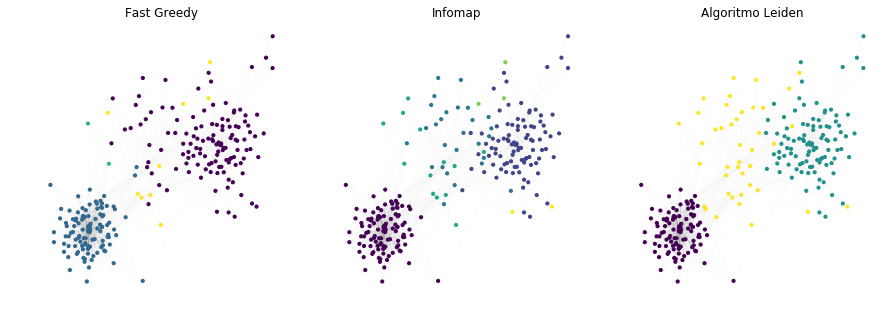

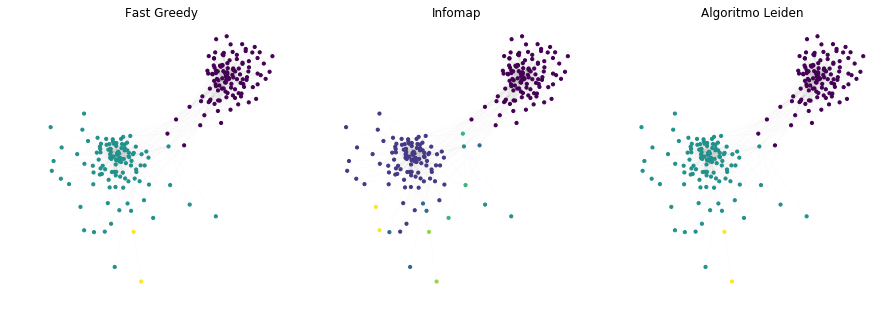

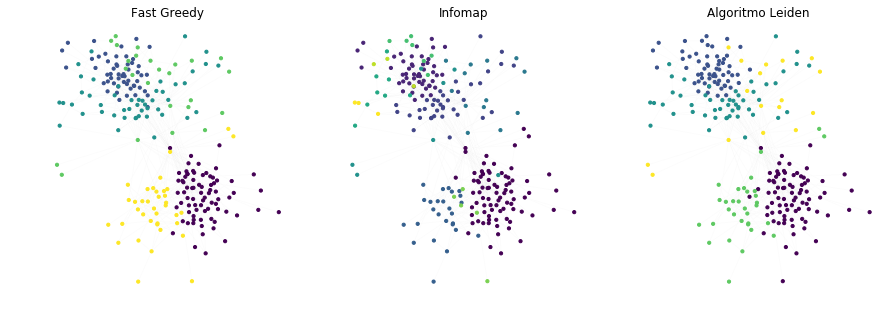

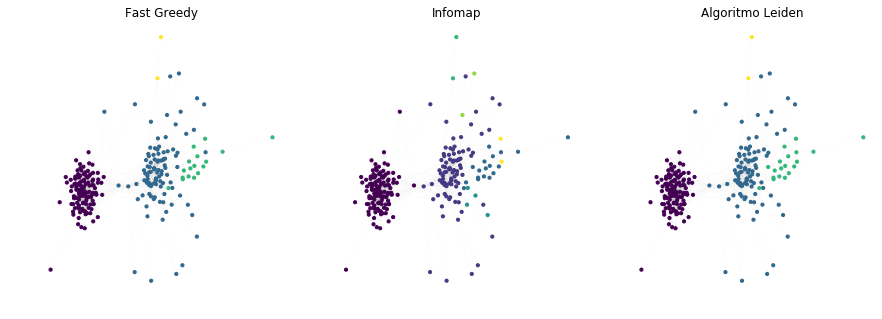

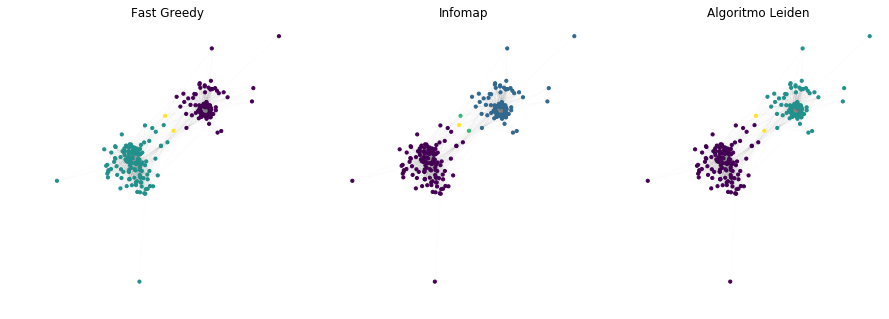

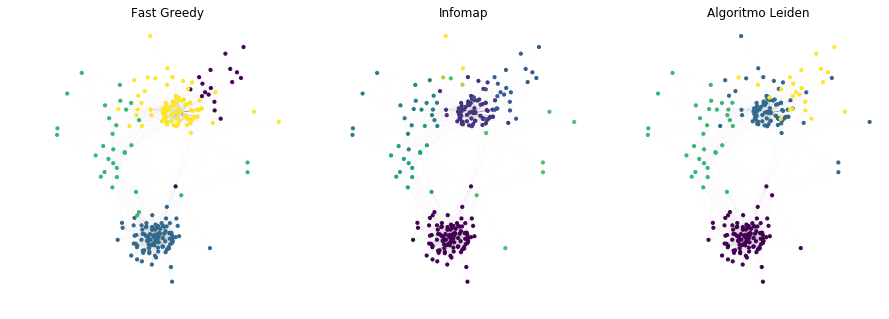

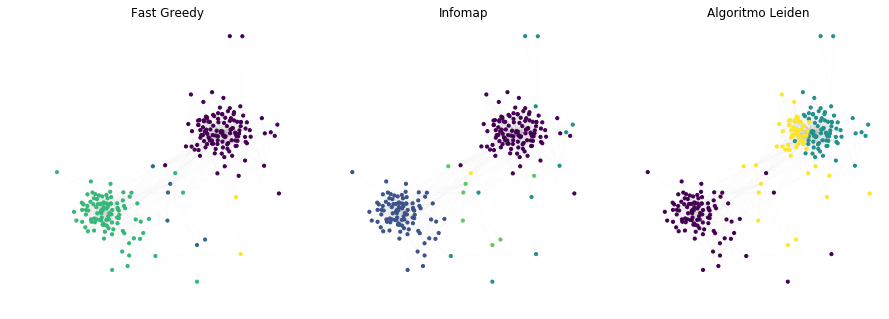

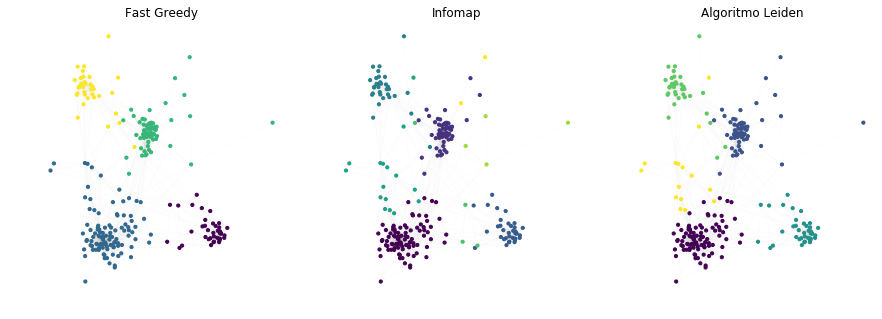

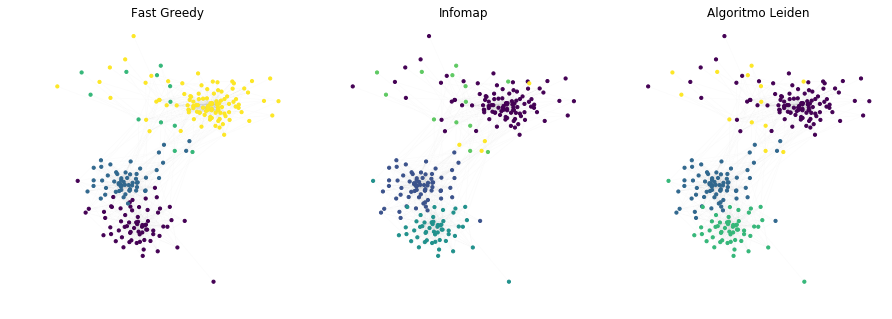

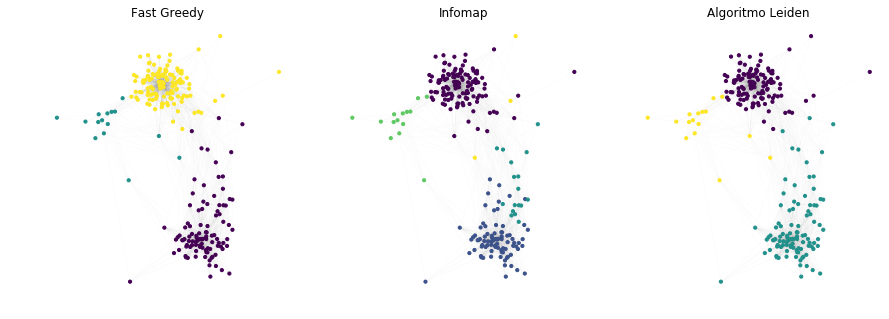

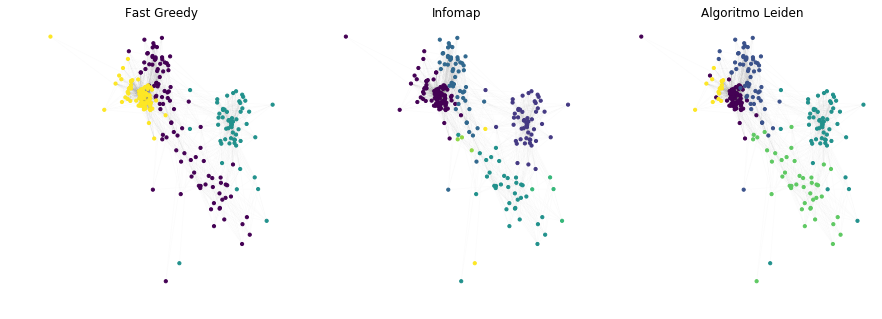

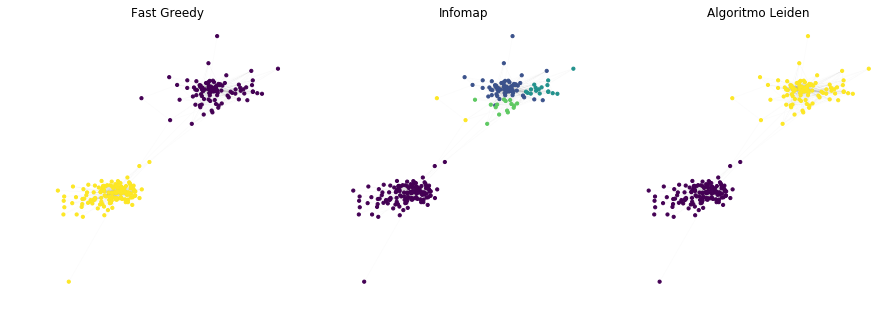

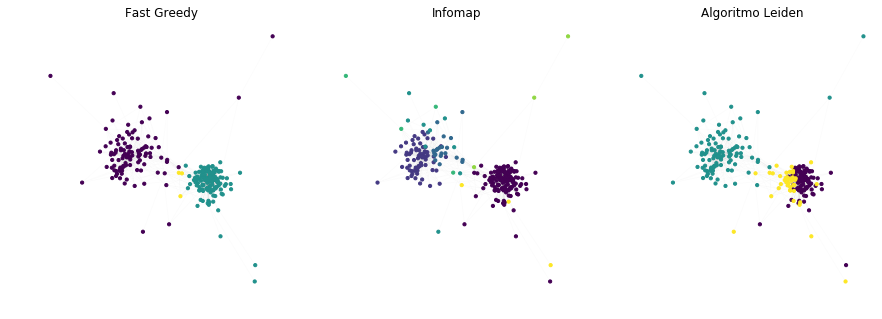

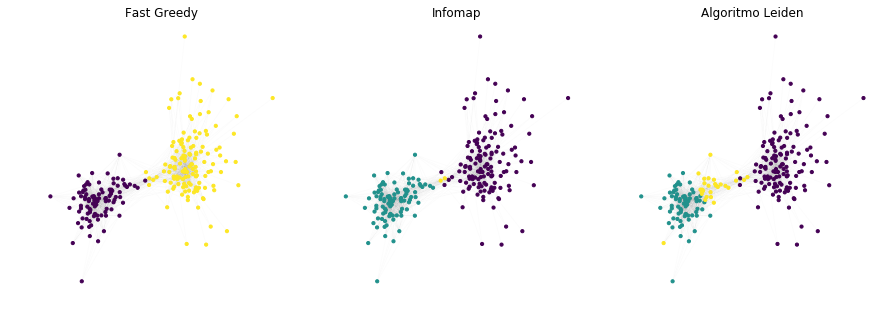

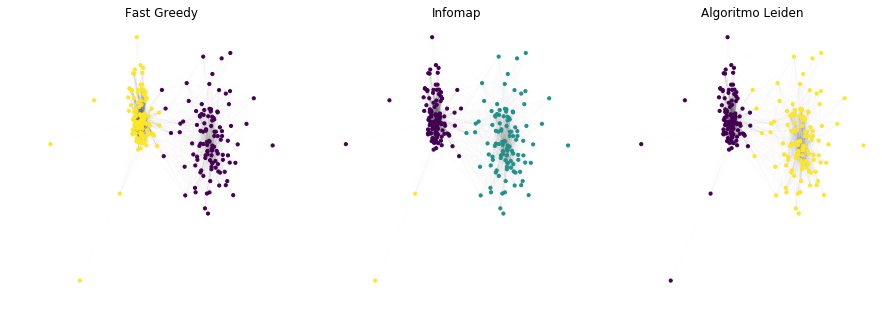

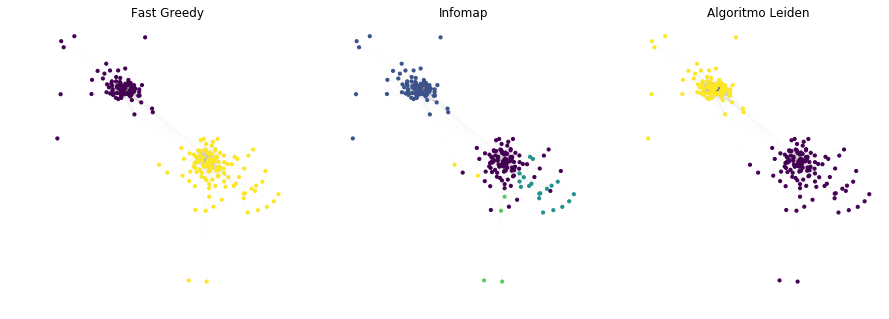

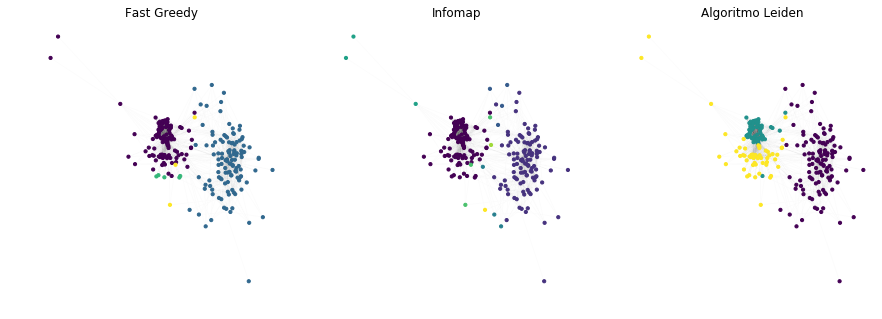

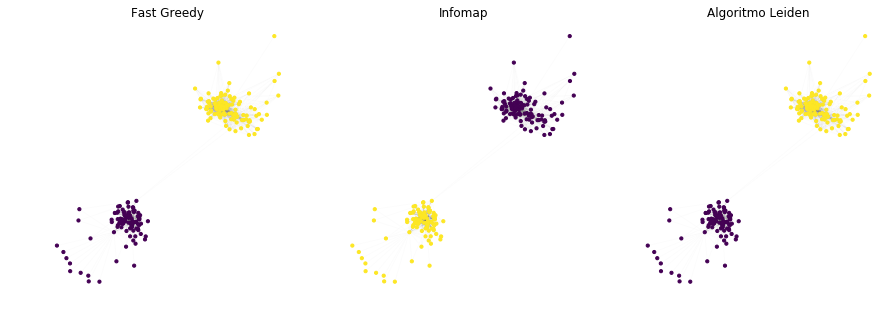

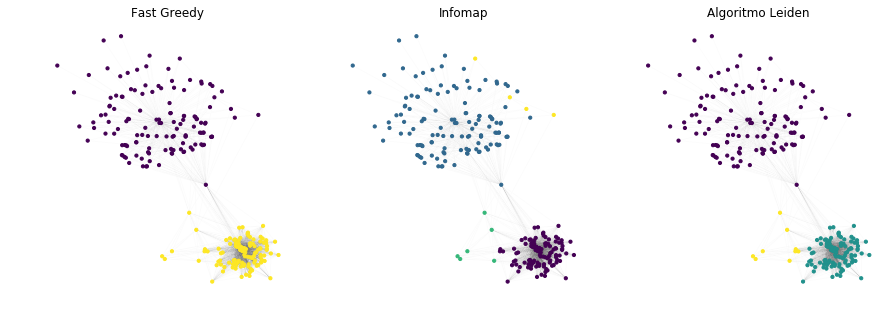

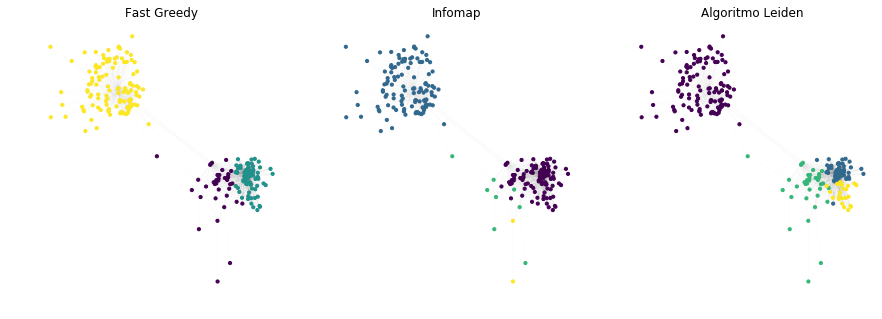

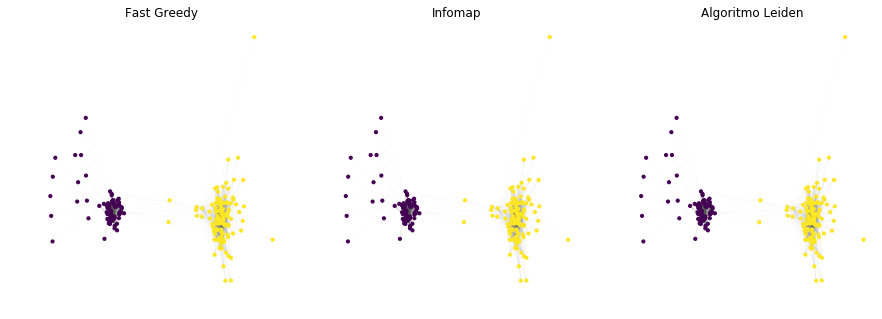

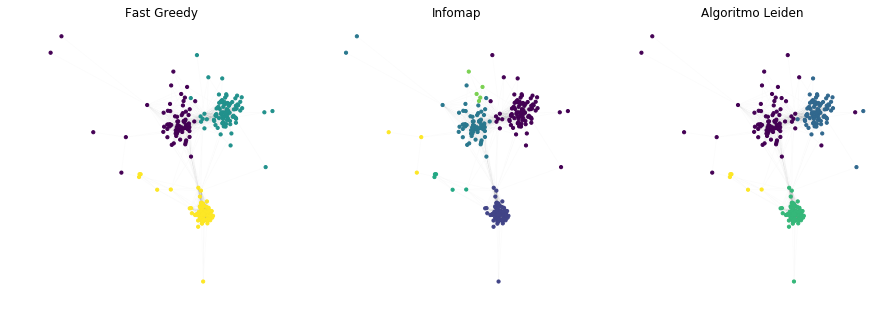

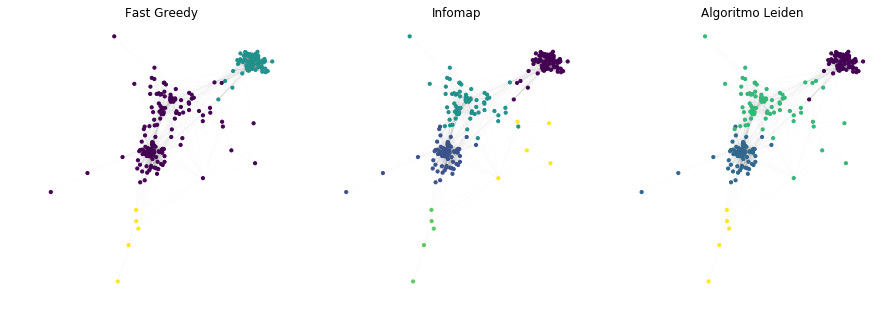

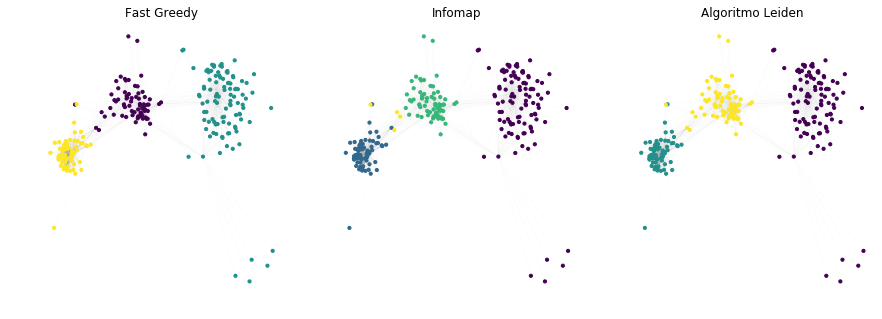

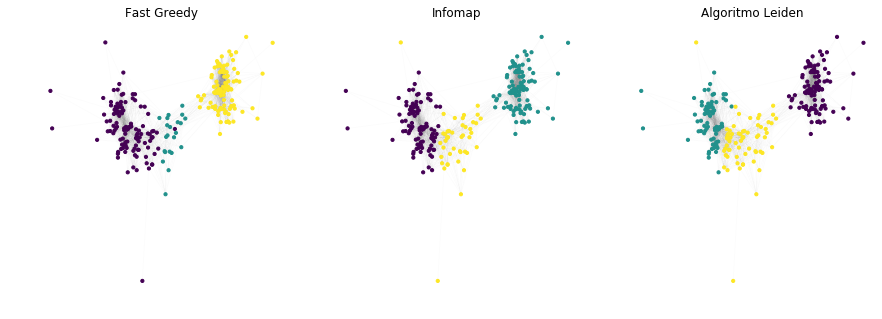

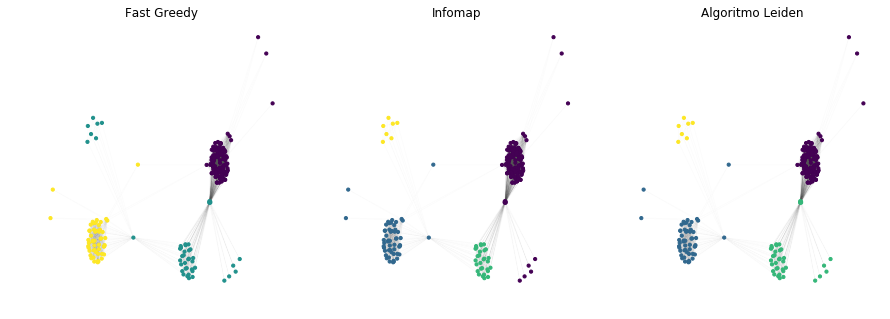

In [104]:
import json
for year in years:

    grafo = get_GC(year,alphas[year],congress)
    dict_ideo = get_ideologies_dict(grafo,year)
    dict_ideo
    
    algoritmos = {'Fast Greedy': f.fast_greedy,'Infomap': f.infomap,'Algoritmo Leiden': f.leiden1}
    particiones = {}
    for i,metodo in enumerate(algoritmos):
        particiones[metodo] = {}
        particion = algoritmos[metodo](grafo.graph,get_weights(grafo))
        particiones[metodo] = particion
        
    dict_comm = get_community_dict(particiones)
    dict_a_guardar = {}
    intersection(dict_comm,dict_ideo, dict_a_guardar)
    
    plot_graph_ideologies(particiones,grafo.graph)

    plt.savefig(f'../figs/community_graphs/particion_{year}.jpg')
    with open(f'metrics/{year}_overlap_data.json', 'w') as outfile:
        json.dump(dict_a_guardar, outfile)
        

## Prueba
Esta es la prueba para un anio solo

In [27]:
year = 2019
alpha = 0.17

In [ ]:
plot_graph_ideologies(grafo,year)

In [67]:
algoritmos = {'Fast Greedy': f.fast_greedy,'Infomap': f.infomap,'Algoritmo Leiden': f.leiden1}
particiones = {}
for i,metodo in enumerate(algoritmos):
    particiones[metodo] = {}
    particion = algoritmos[metodo](grafo.graph,get_weights(grafo))
    particiones[metodo] = particion

In [68]:
dict_comm = get_community_dict(particiones)
dict_a_guardar = {}
intersection(dict_comm,dict_ideo, dict_a_guardar)

{'Fast Greedy': {'Partición 0': {'Tamaño (nodos)': 120,
   'Justicialismo': 0.525,
   'Cambiemos': 0.016666666666666666,
   'Peronismo disidente': 0.15},
  'Partición 1': {'Tamaño (nodos)': 22,
   'Justicialismo': 0.0,
   'Cambiemos': 0.0,
   'Peronismo disidente': 0.4090909090909091},
  'Partición 2': {'Tamaño (nodos)': 102,
   'Justicialismo': 0.0,
   'Cambiemos': 0.9509803921568627,
   'Peronismo disidente': 0.0}},
 'Infomap': {'Partición 0': {'Tamaño (nodos)': 98,
   'Justicialismo': 0.6326530612244898,
   'Cambiemos': 0.0,
   'Peronismo disidente': 0.08163265306122448},
  'Partición 1': {'Tamaño (nodos)': 102,
   'Justicialismo': 0.0,
   'Cambiemos': 0.9509803921568627,
   'Peronismo disidente': 0.0},
  'Partición 2': {'Tamaño (nodos)': 44,
   'Justicialismo': 0.022727272727272728,
   'Cambiemos': 0.045454545454545456,
   'Peronismo disidente': 0.4318181818181818}},
 'Algoritmo Leiden': {'Partición 0': {'Tamaño (nodos)': 102,
   'Justicialismo': 0.0,
   'Cambiemos': 0.950980392156

In [75]:
import pandas as pd
#fastgreedy algo
nodos_df = dict_a_guardar[list(dict_a_guardar.keys())[0]].copy() #no modificar data
df = pd.DataFrame(nodos_df).transpose()
df = df.astype(float).round(3)

df

,Cambiemos,Justicialismo,Peronismo disidente,Tamaño (nodos)
Partición 0,0.000,0.910,0.033,122.0
Partición 1,0.851,0.043,0.064,47.0
Partición 2,0.981,0.000,0.000,52.0


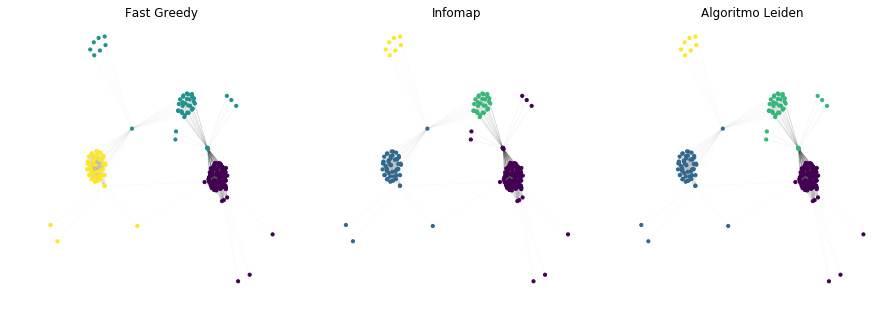

In [103]:
plot_graph_ideologies(particiones,grafo.graph)